In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
df_brl = pd.read_parquet('../data/all_comm/all_commodities_brl.parquet')

In [5]:
Y_test_df_brl = df_brl.groupby('unique_id').tail(24)
remaining = df_brl.drop(Y_test_df_brl.index, axis = 0)
X_val_df_brl = remaining.groupby('unique_id').tail(12)
X_train_df_brl = remaining.drop(X_val_df_brl.index, axis=0)

In [6]:
X_train_df_brl.head()

,ds,y,unique_id
0,2020-01-02,65.40,ACUCAR_SANTOS
1,2020-01-03,66.80,ACUCAR_SANTOS
2,2020-01-06,68.92,ACUCAR_SANTOS
3,2020-01-07,68.85,ACUCAR_SANTOS
4,2020-01-08,68.32,ACUCAR_SANTOS


In [7]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()


# def prepare_data(df):
#     df_copy = df.copy()
#     # Agrupar por commodity para normalizar separadamente
#     for commodity in df_copy['unique_id'].unique():
#         mask = df_copy['unique_id'] == commodity
#         df_copy.loc[mask, 'y'] = scaler.fit_transform(df_copy.loc[mask, 'y'].values.reshape(-1, 1))
#     return df_copy


# X_train_df_brl = prepare_data(X_train_df_brl)
# X_val_df_brl = prepare_data(X_val_df_brl)
# Y_test_df_brl = prepare_data(Y_test_df_brl)

In [8]:
models = [
    LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ),
    MLPRegressor(
        hidden_layer_sizes=(50, 25),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        random_state=42
    )
]

fcst = MLForecast(
    models=models,
    freq='ME',
    lags=[1, 2, 3, 4, 5, 6],
    date_features=['month', 'year'],
    num_threads=4
)

In [9]:
fcst.fit(
    df=X_train_df_brl,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 58899, number of used features: 8
[LightGBM] [Info] Start training from score 283.848698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

MLForecast(models=[LGBMRegressor, XGBRegressor, KNeighborsRegressor, MLPRegressor, RandomForestRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'], date_features=['month', 'year'], num_threads=4)

In [10]:
forecasts_val = fcst.predict(h=12)

In [11]:
full_train = pd.concat([X_train_df_brl, X_val_df_brl])
fcst.fit(full_train)  
forecasts_test = fcst.predict(h=24)
forecasts_test = forecasts_test.reset_index()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 59031, number of used features: 8
[LightGBM] [Info] Start training from score 284.965371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [12]:
forecasts_test.head()

,index,unique_id,ds,LGBMRegressor,XGBRegressor,KNeighborsRegressor,MLPRegressor,RandomForestRegressor
0,0,ACUCAR_SANTOS,2025-03-31,144.073889,144.312714,145.710026,146.046371,172.342666
1,1,ACUCAR_SANTOS,2025-04-30,143.632037,144.312714,145.832449,144.477877,172.342666
2,2,ACUCAR_SANTOS,2025-05-31,143.632037,144.312714,145.212778,143.688106,172.342666
3,3,ACUCAR_SANTOS,2025-06-30,143.632037,144.289886,145.289733,142.575877,172.342666
4,4,ACUCAR_SANTOS,2025-07-31,143.632037,144.289886,145.444635,141.527148,172.342666


In [13]:
metrics_df = pd.DataFrame()

for commodity in Y_test_df_brl['unique_id'].unique():
    actual = Y_test_df_brl[Y_test_df_brl['unique_id'] == commodity]['y']
    
    for model in ['LGBMRegressor', 'XGBRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'RandomForestRegressor']:
        pred = forecasts_test[forecasts_test['unique_id'] == commodity][model]
        metrics = evaluate_forecasts(actual, pred)
        
        temp_df = pd.DataFrame({
            'Commodity': [commodity],
            'Model': [model],
            'MAE': [metrics['MAE']],
            'MAPE': [metrics['MAPE']],
            'MSE': [metrics['MSE']],
            'RMSE': [metrics['RMSE']],
            'R2': [metrics['R2']]
        })
        
        metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

metrics_df = metrics_df.round(4)

In [14]:
print("Métricas de Erro por Commodity e Modelo:")
metrics_df

Métricas de Erro por Commodity e Modelo:


,Commodity,Model,MAE,MAPE,MSE,RMSE,R2
0,ACUCAR_SANTOS,LGBMRegressor,4.7156,0.0344,34.3901,5.8643,-0.4369
1,ACUCAR_SANTOS,XGBRegressor,4.9482,0.0362,39.0795,6.2514,-0.6329
2,ACUCAR_SANTOS,KNeighborsRegressor,7.2678,0.0532,85.0137,9.2203,-2.5522
3,ACUCAR_SANTOS,MLPRegressor,6.3261,0.0456,47.4164,6.8860,-0.9812
4,ACUCAR_SANTOS,RandomForestRegressor,31.9668,0.2292,1045.8113,32.3390,-42.6976
5,ACUCAR_SP,LGBMRegressor,1.7494,0.0123,4.3059,2.0751,-0.2263
6,ACUCAR_SP,XGBRegressor,2.6372,0.0185,9.6875,3.1125,-1.7589
7,ACUCAR_SP,KNeighborsRegressor,7.6073,0.0533,72.4323,8.5107,-19.6280
8,ACUCAR_SP,MLPRegressor,17.3204,0.1214,377.2778,19.4236,-106.4451
9,ACUCAR_SP,RandomForestRegressor,30.5243,0.2154,935.2462,30.5818,-265.3491


In [15]:
print("\nMétricas Médias por Modelo:")
print(metrics_df.groupby('Model')[['MAE', 'RMSE', 'MAPE', 'R2']].mean().round(4))


Métricas Médias por Modelo:
                            MAE      RMSE    MAPE        R2
Model                                                      
KNeighborsRegressor     45.2567   51.9095  0.0472   -6.1917
LGBMRegressor          105.5151  110.8330  0.0772  -35.0129
MLPRegressor            59.3942   65.5403  0.0907  -90.5832
RandomForestRegressor  116.4652  120.0126  0.2222 -336.1430
XGBRegressor            79.9816   83.3989  0.0590   -6.2484


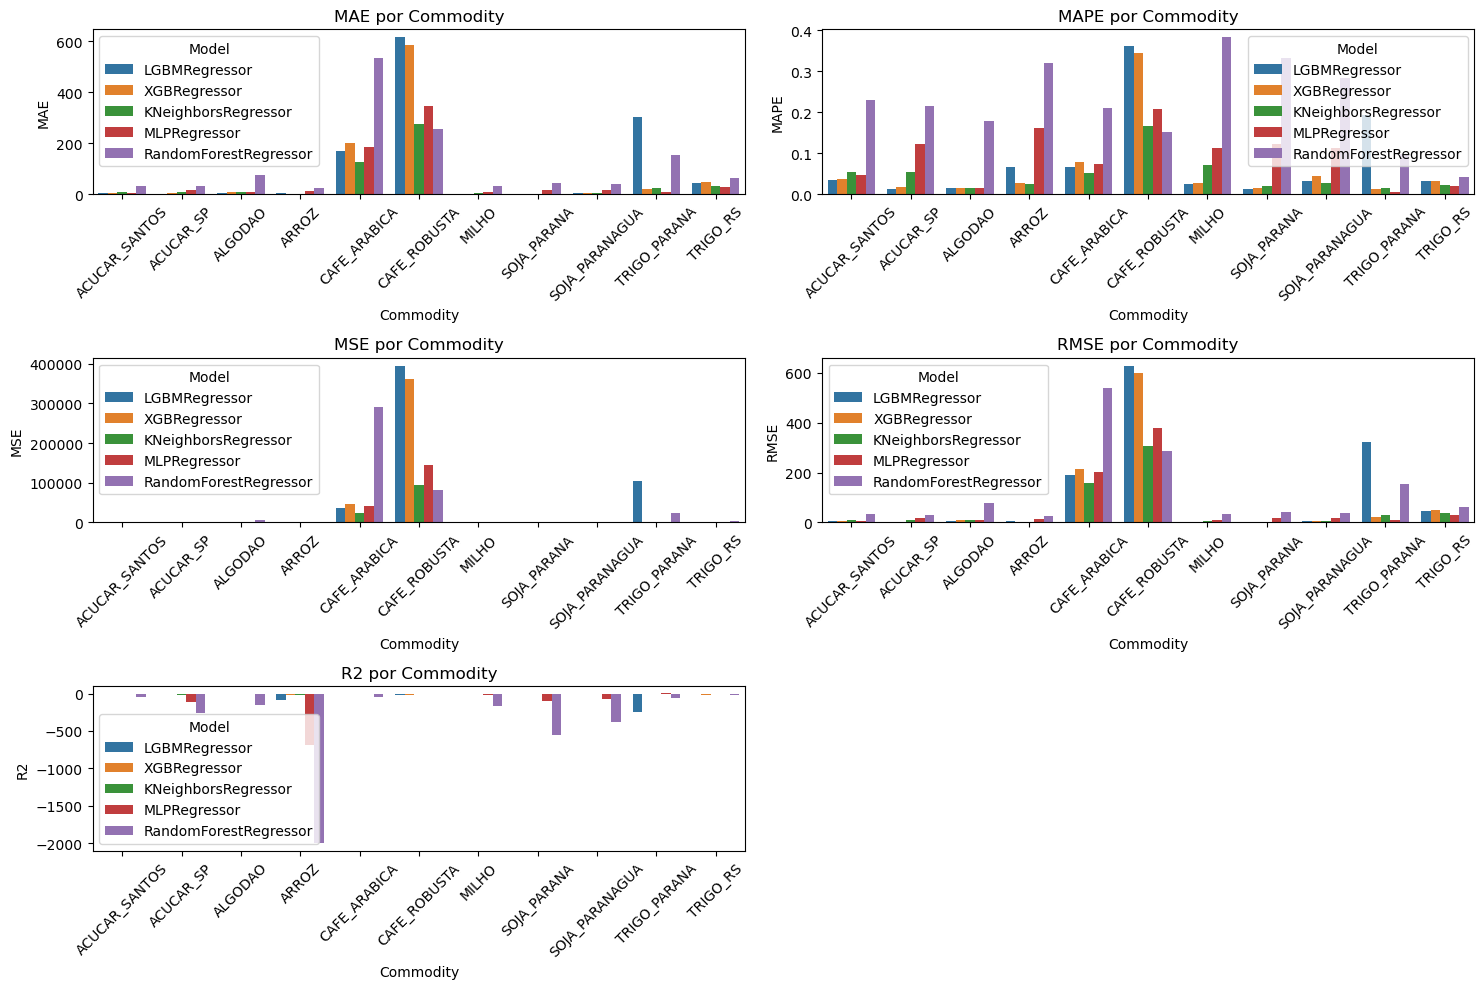

In [16]:
plot_metrics_comparison(metrics_df)

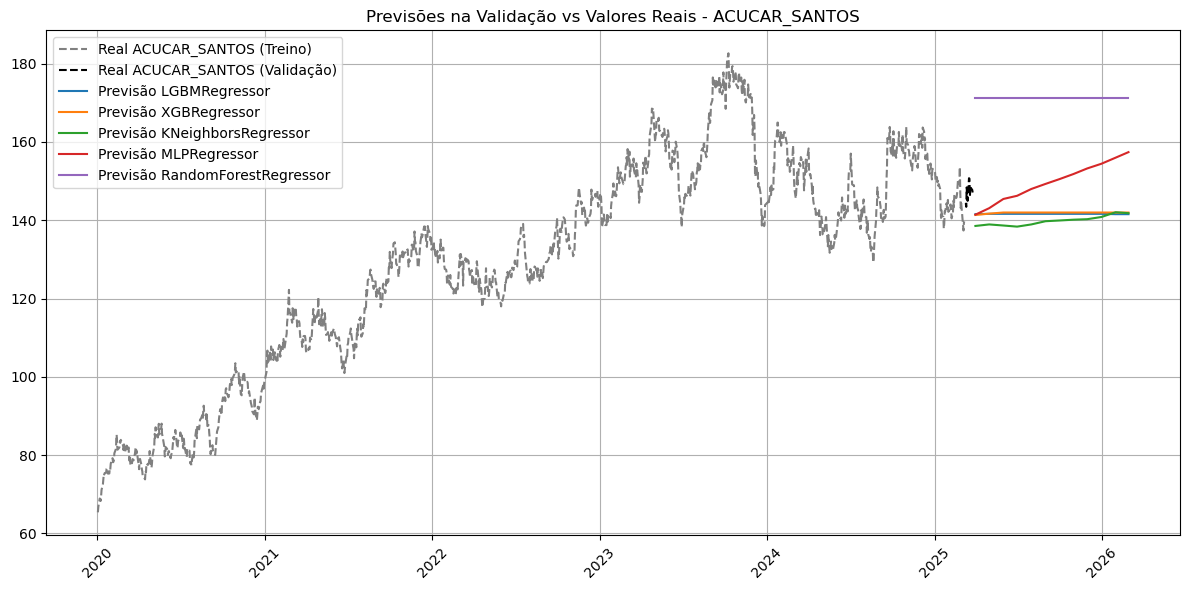

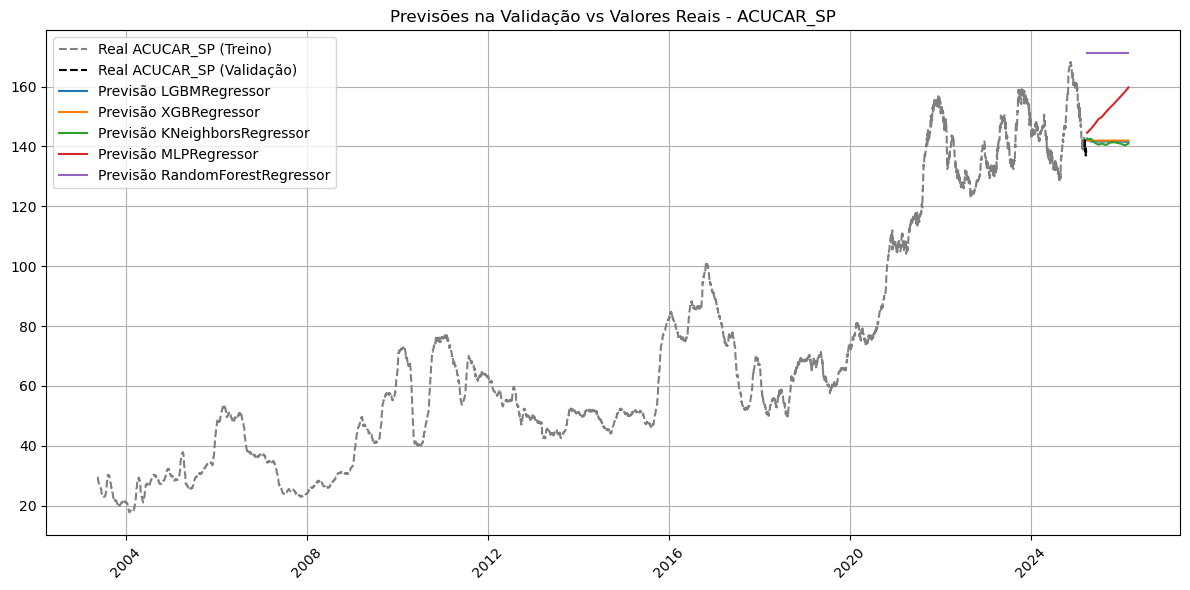

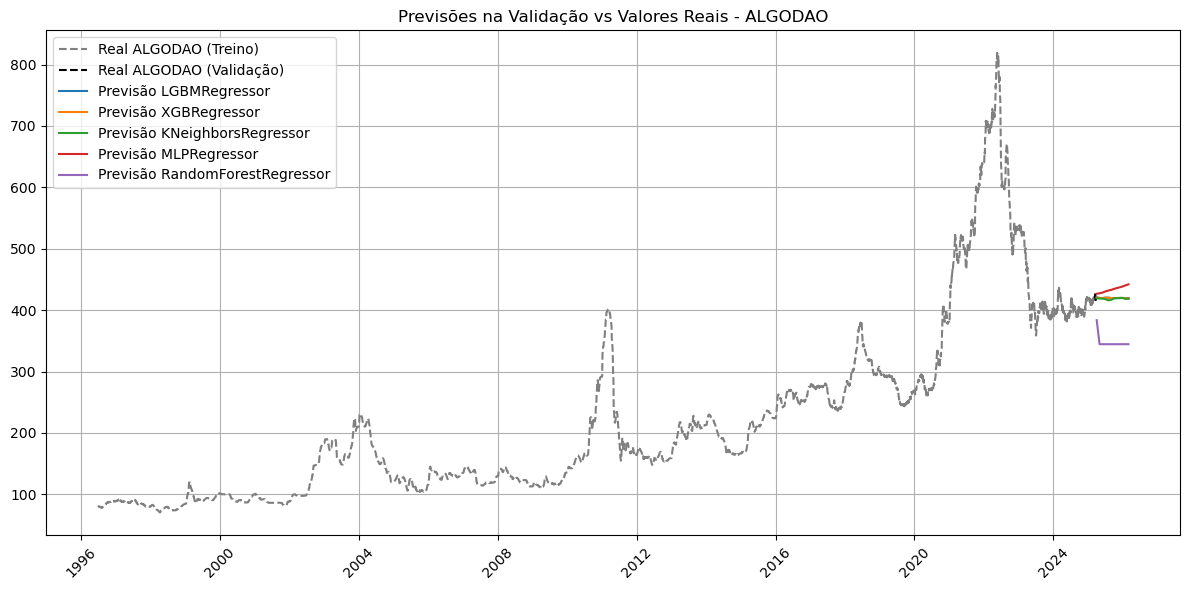

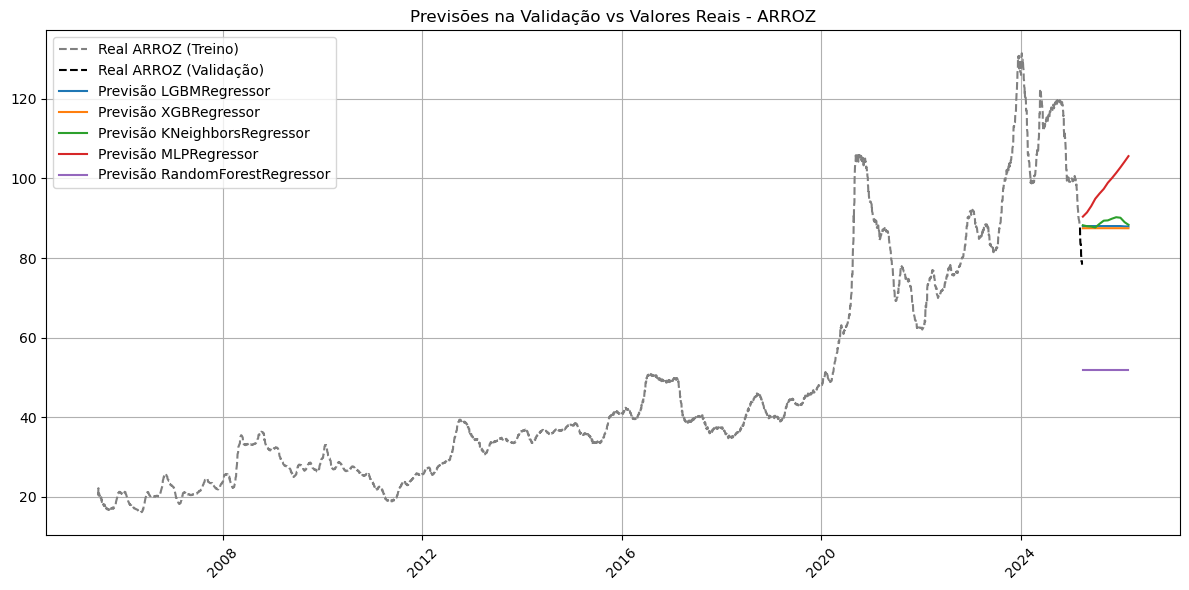

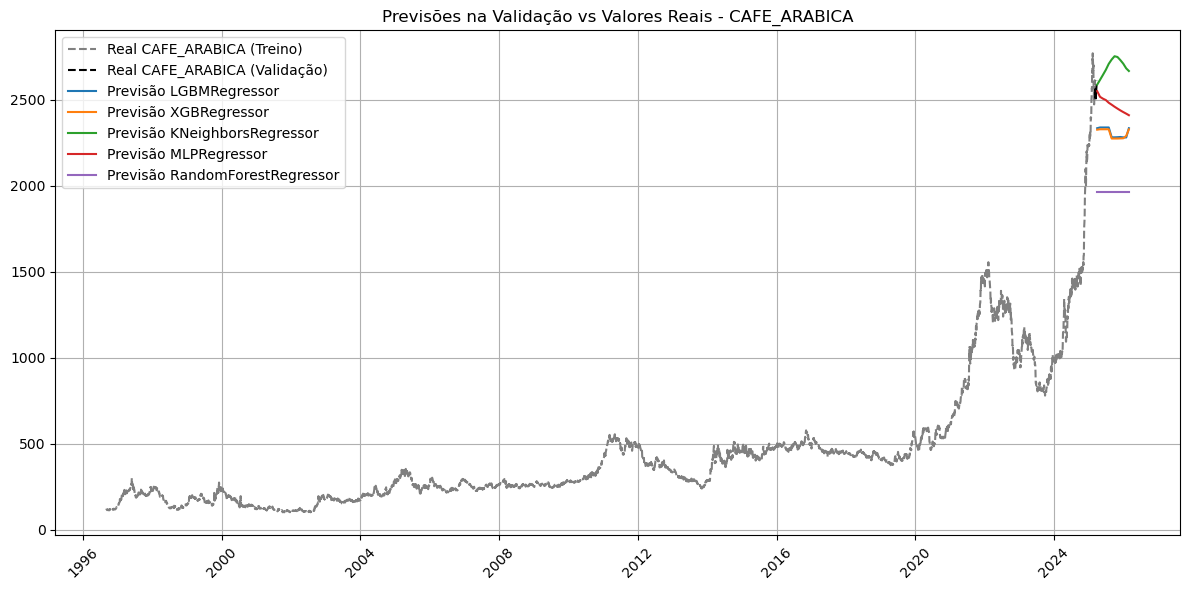

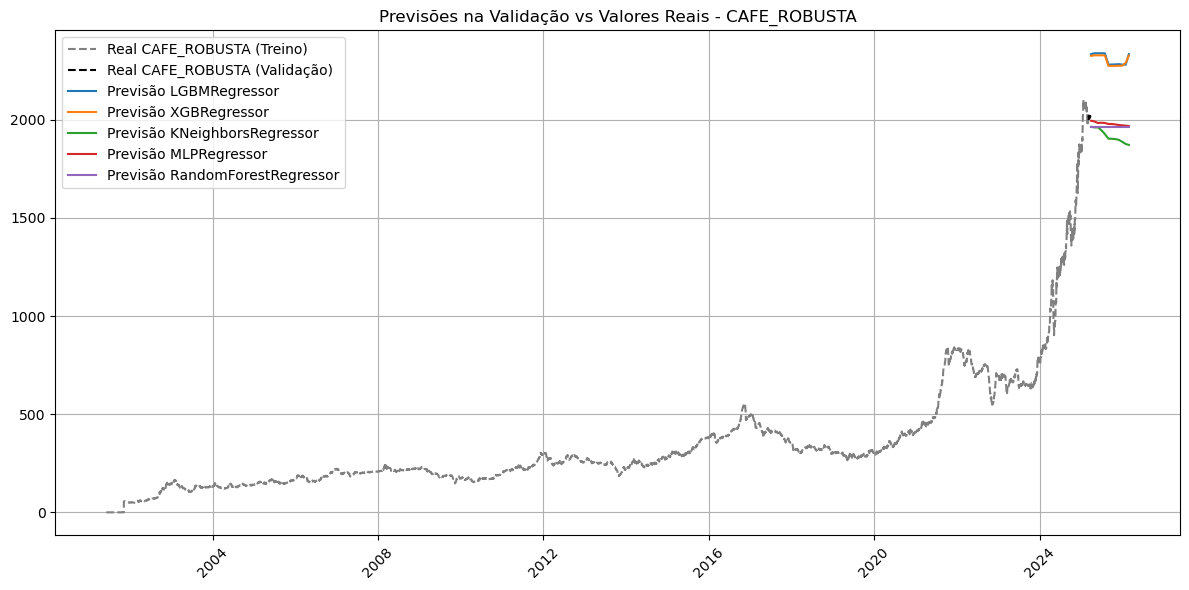

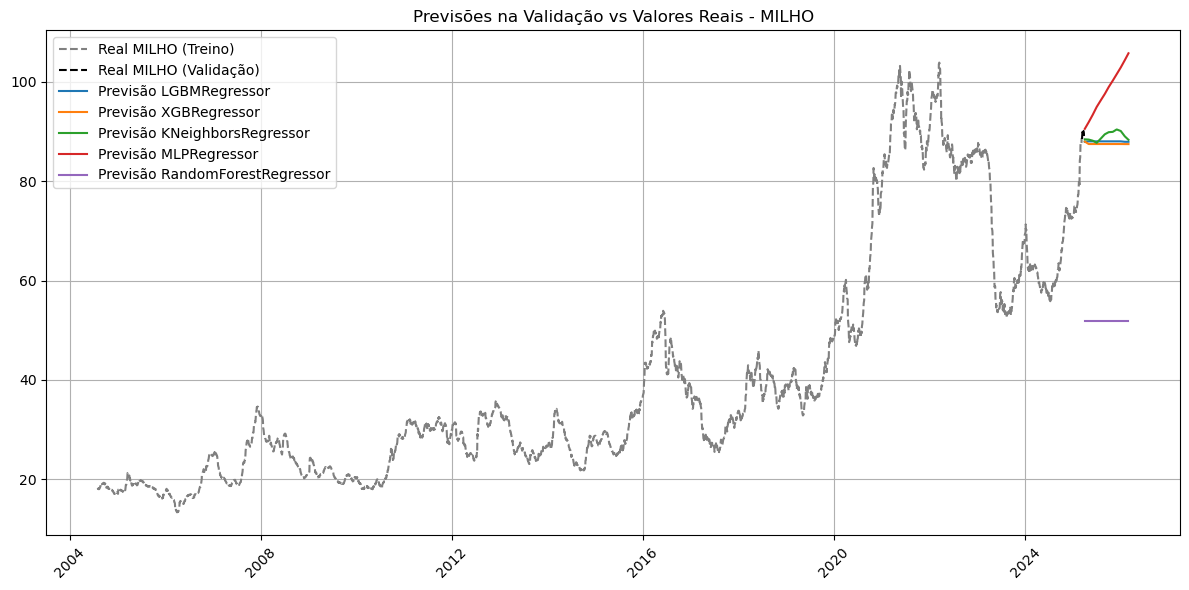

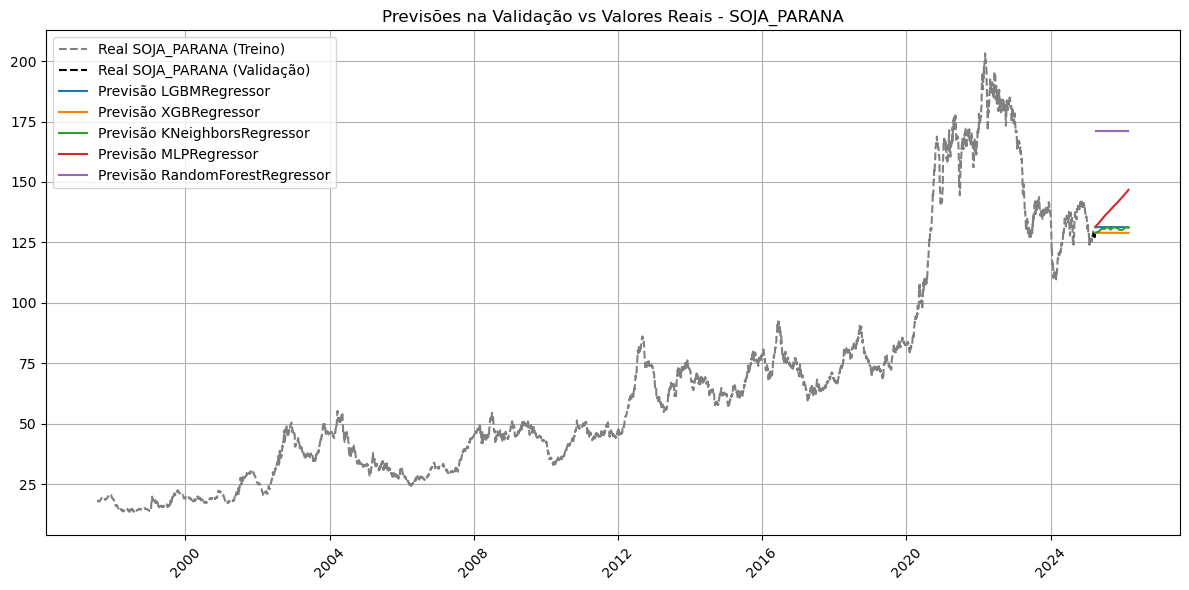

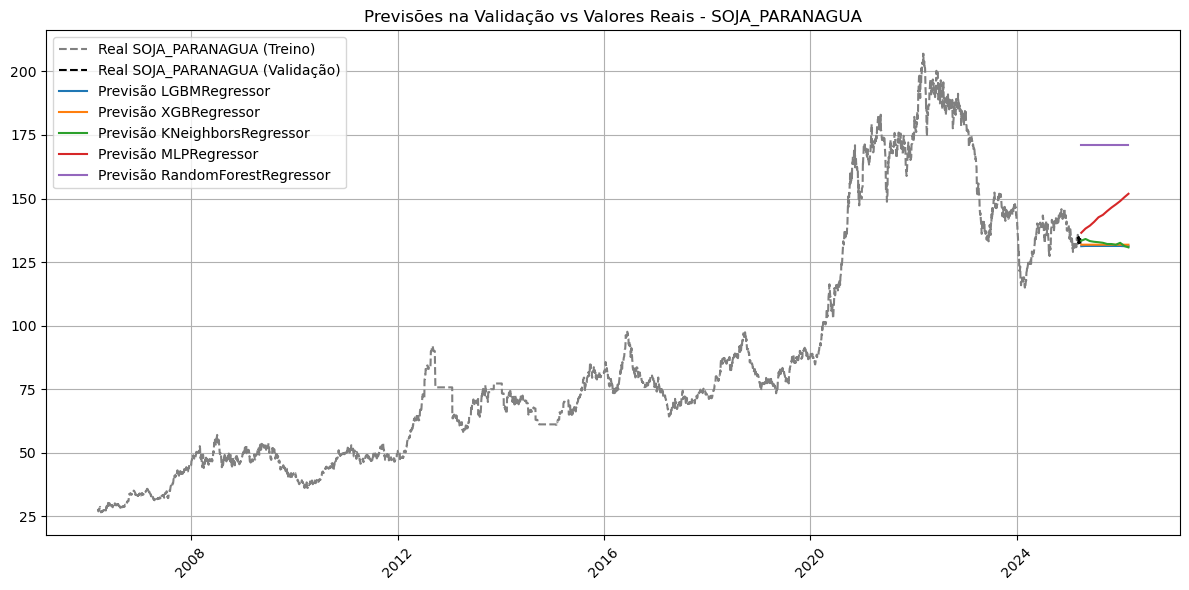

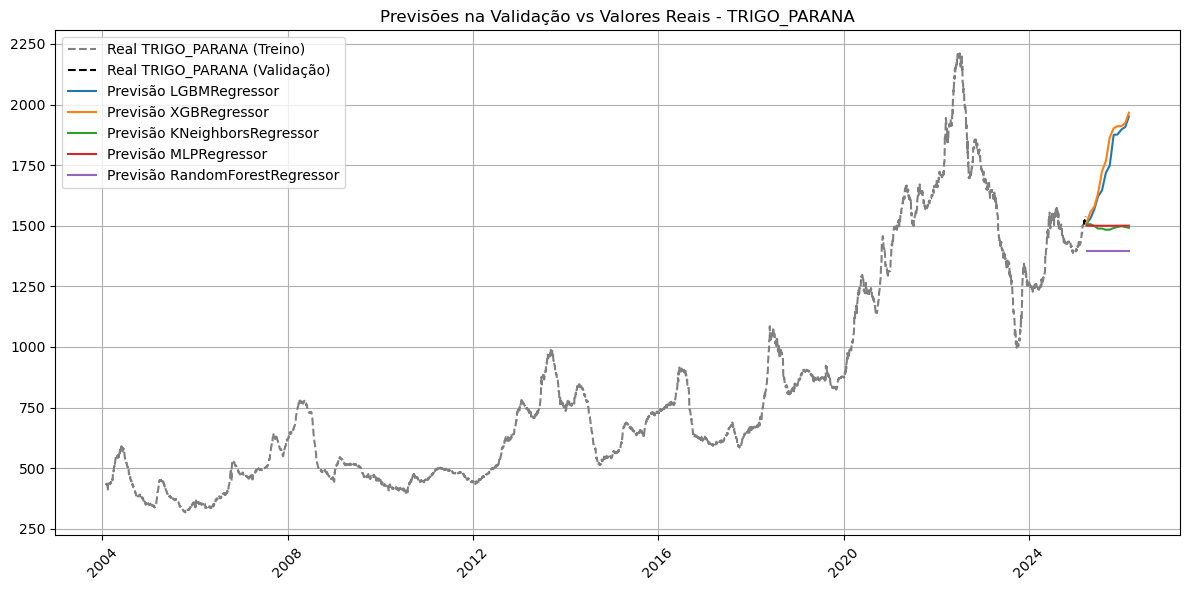

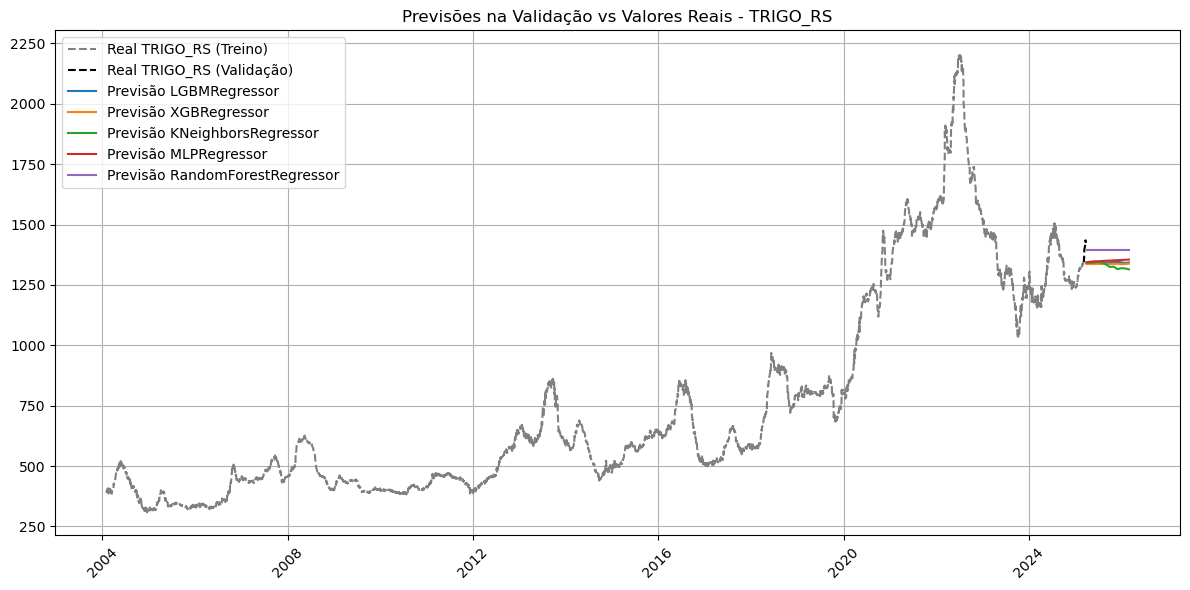

In [17]:
for commodity in X_val_df_brl['unique_id'].unique():
    plot_validation_forecasts(
        train_data=X_train_df_brl,
        val_data=X_val_df_brl,
        forecasts_val=forecasts_val,
        commodity=commodity,
        models=['LGBMRegressor', 'XGBRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'RandomForestRegressor']
    )

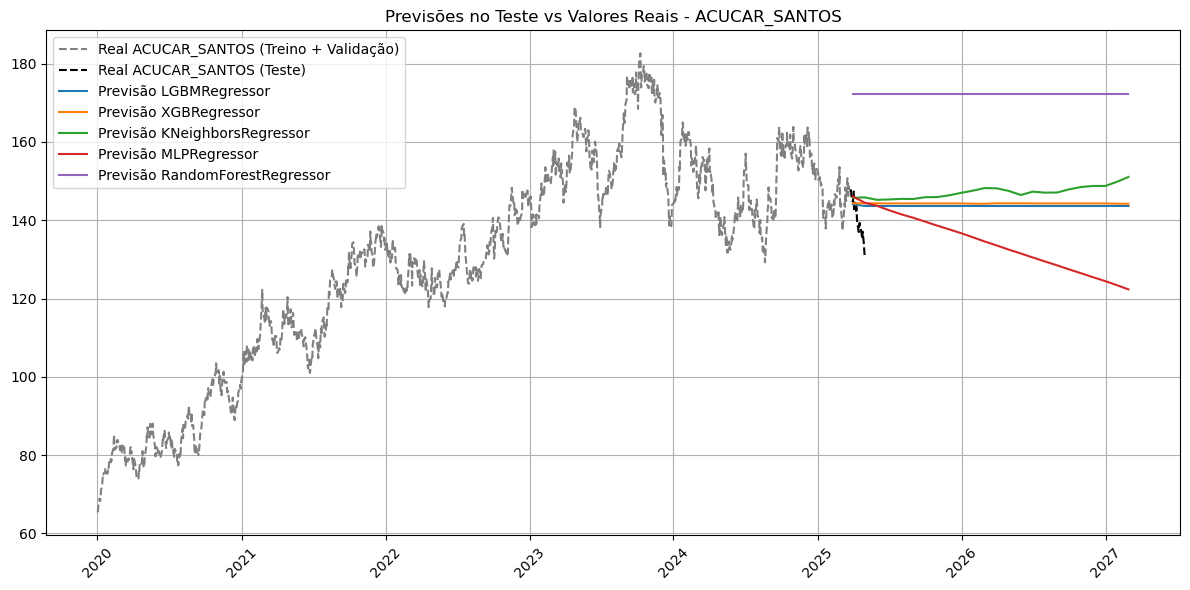

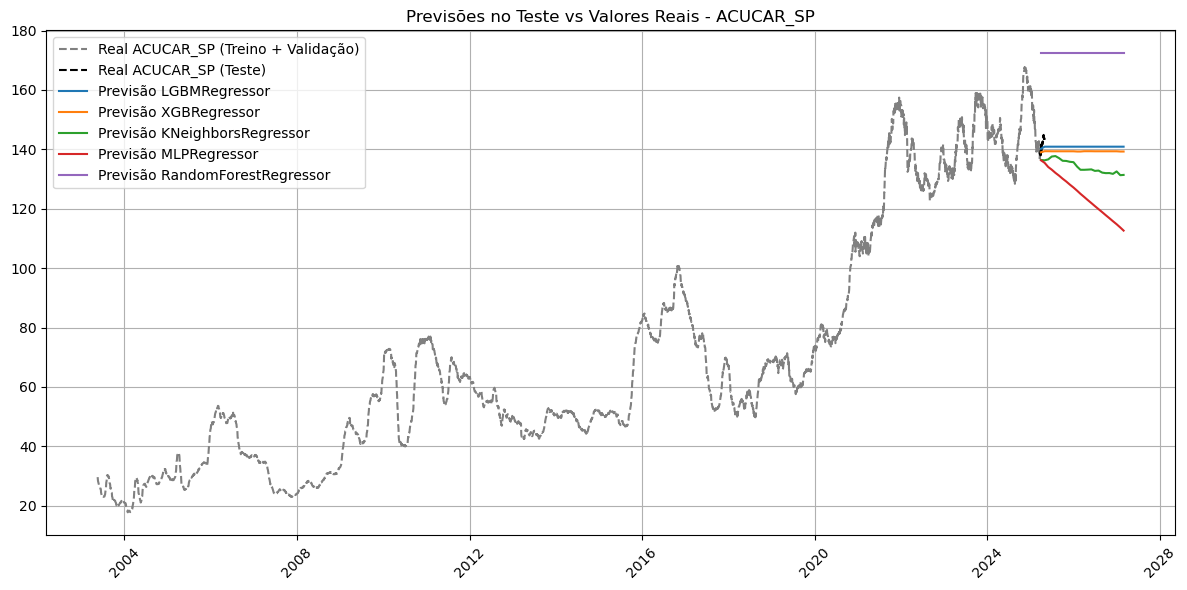

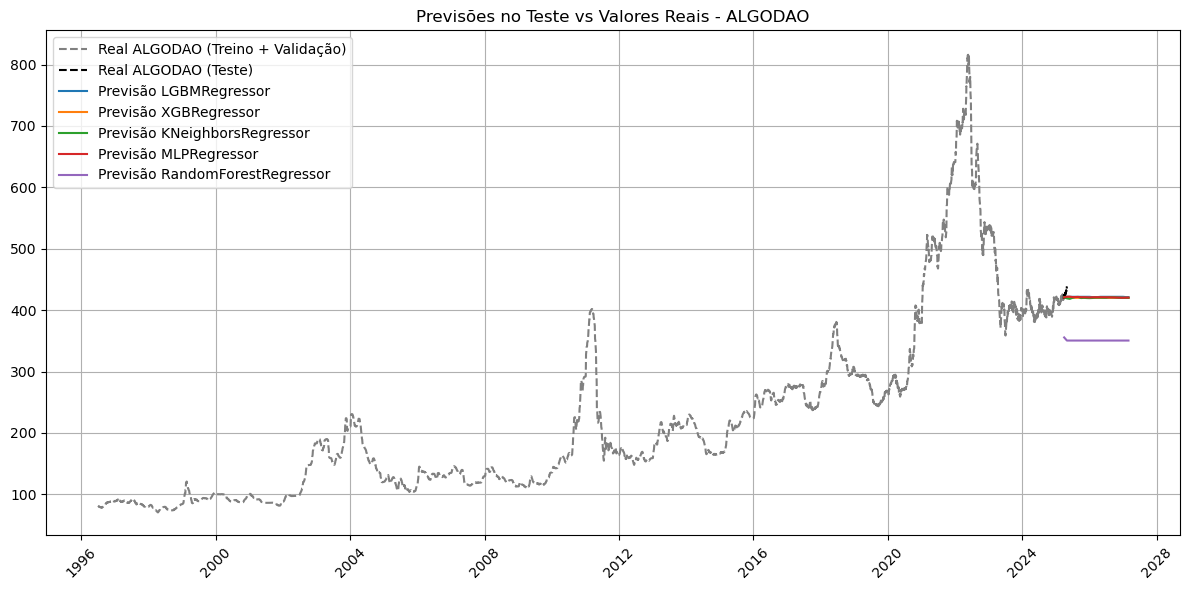

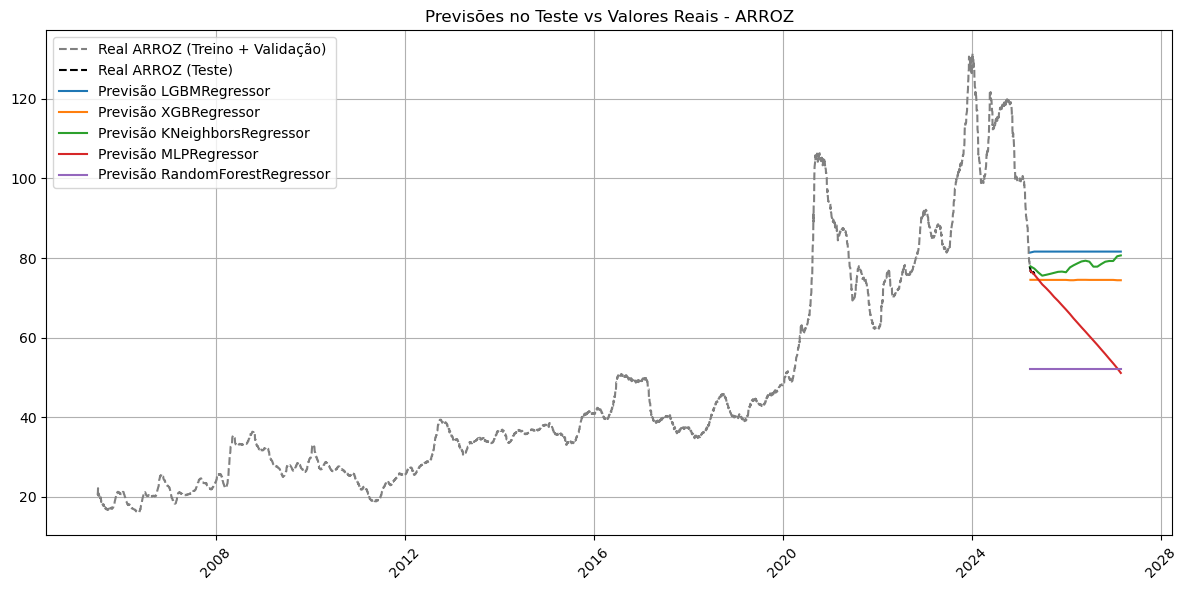

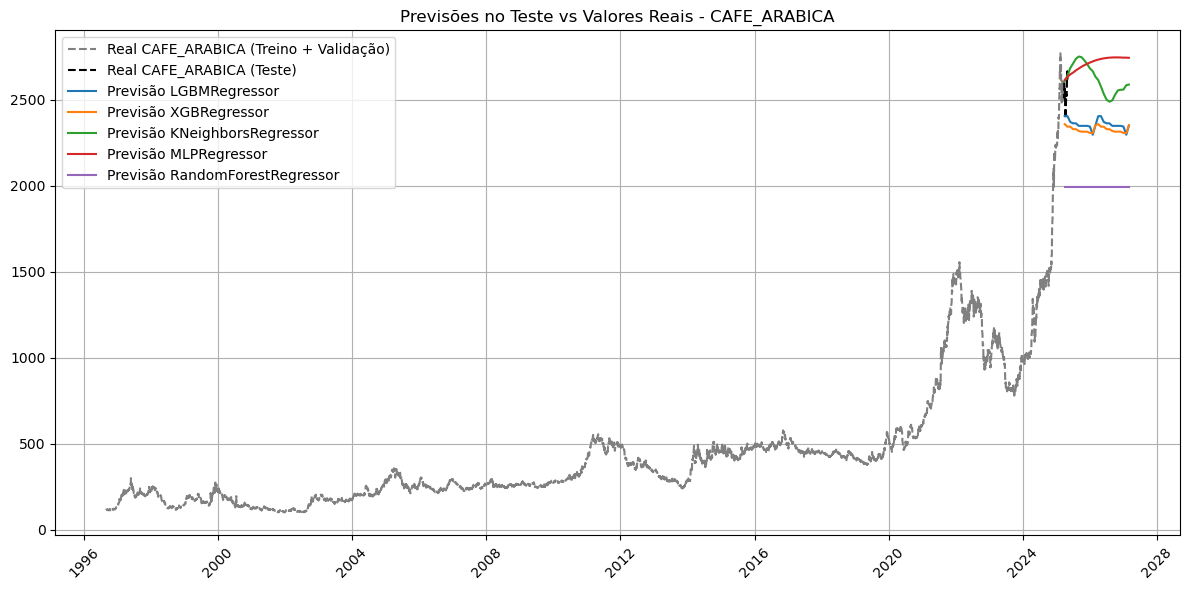

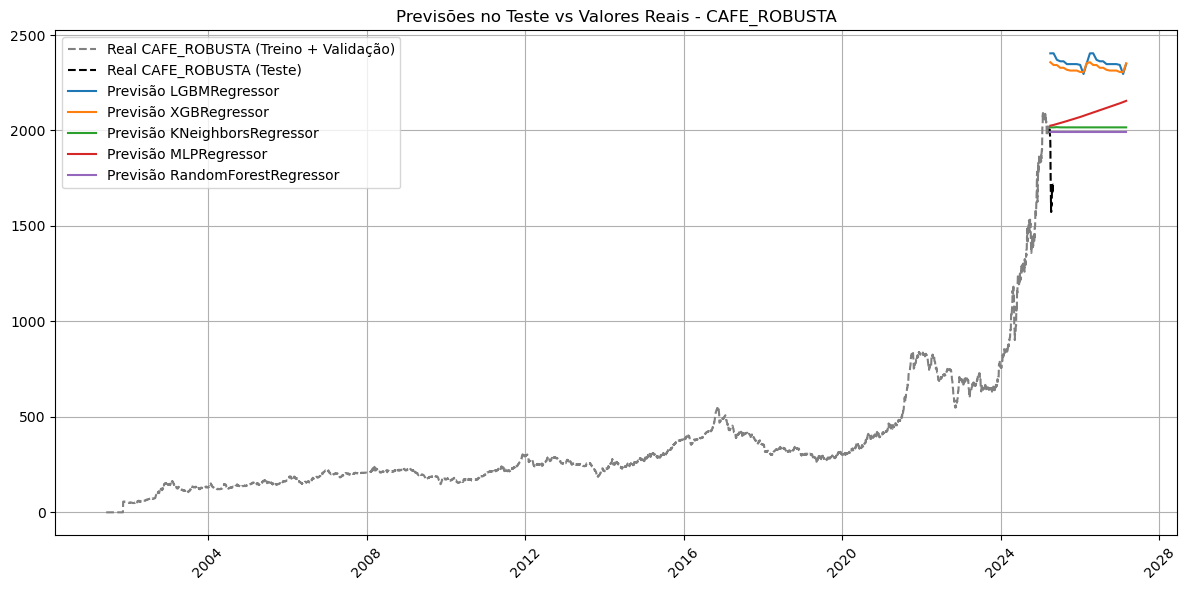

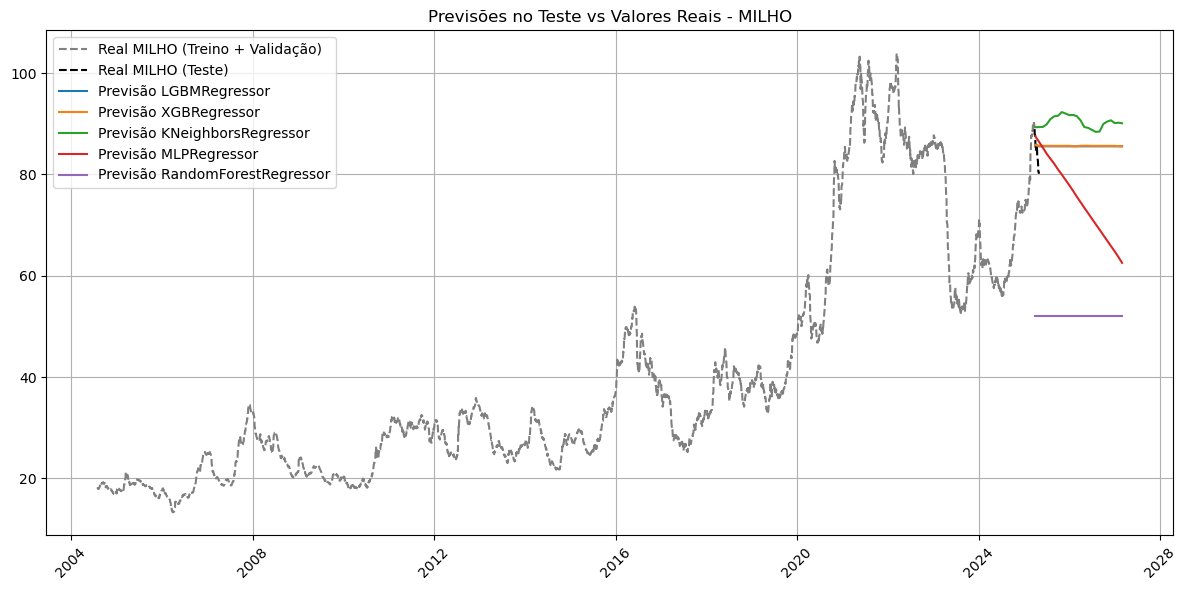

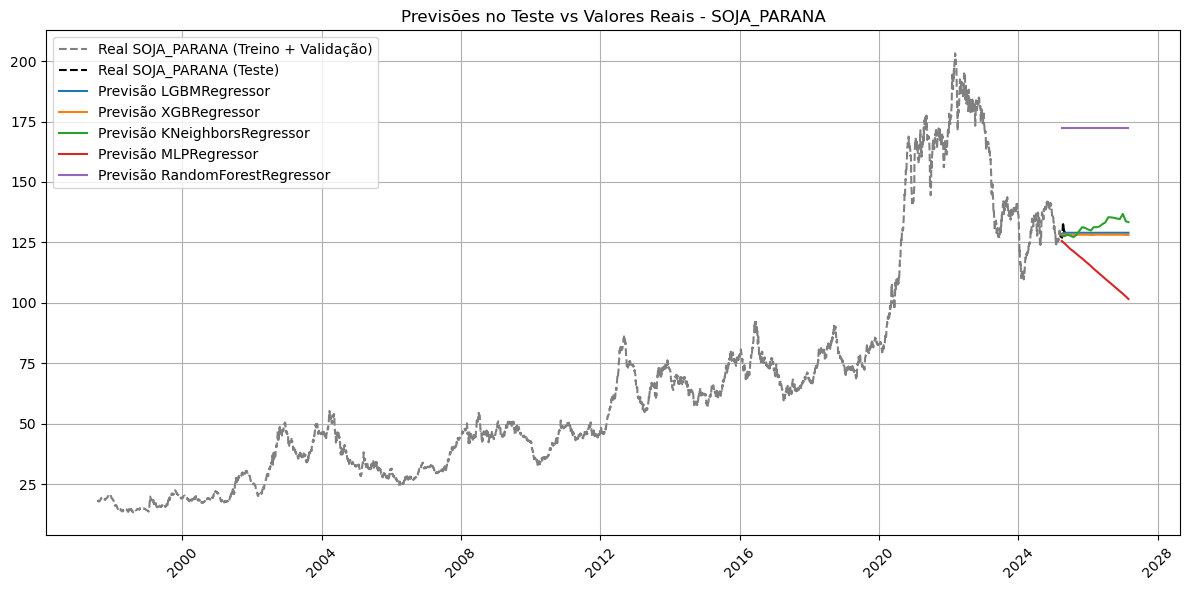

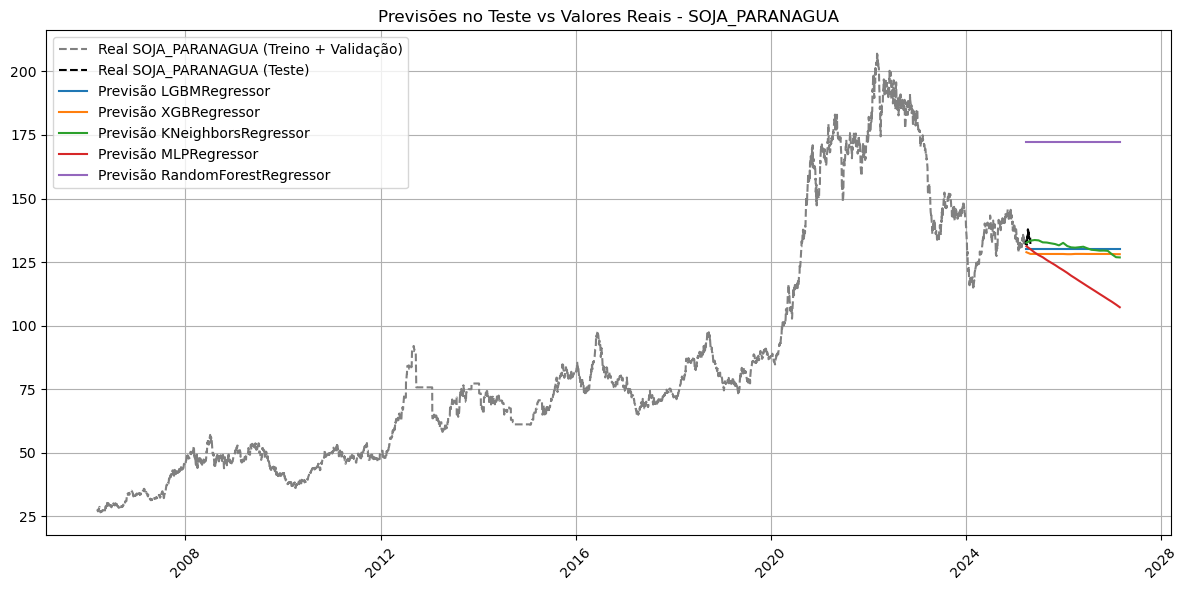

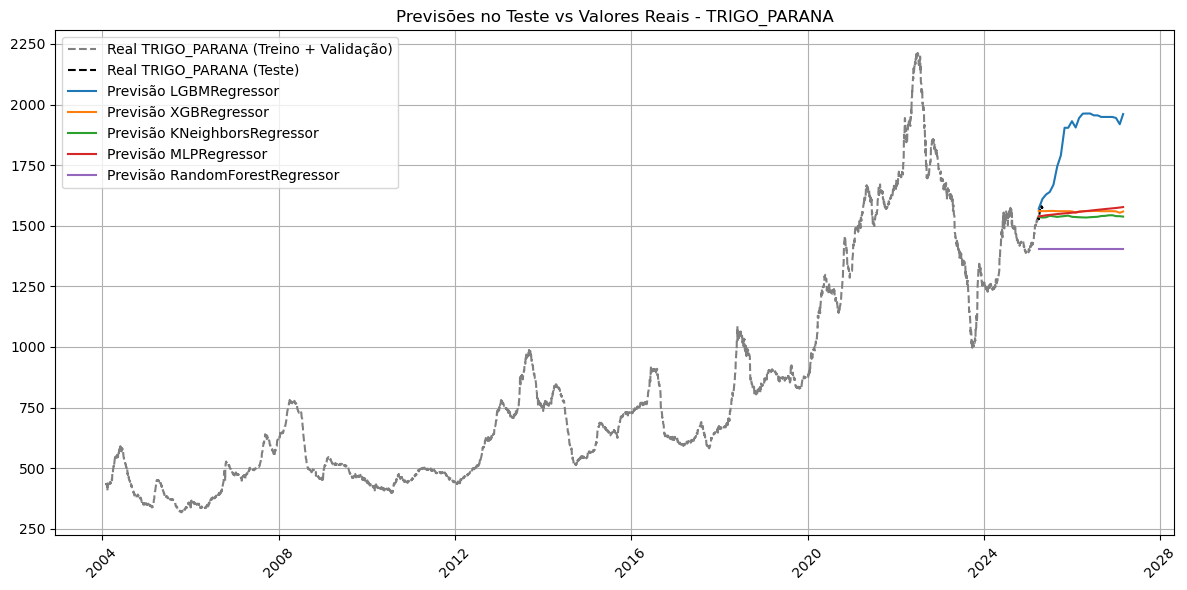

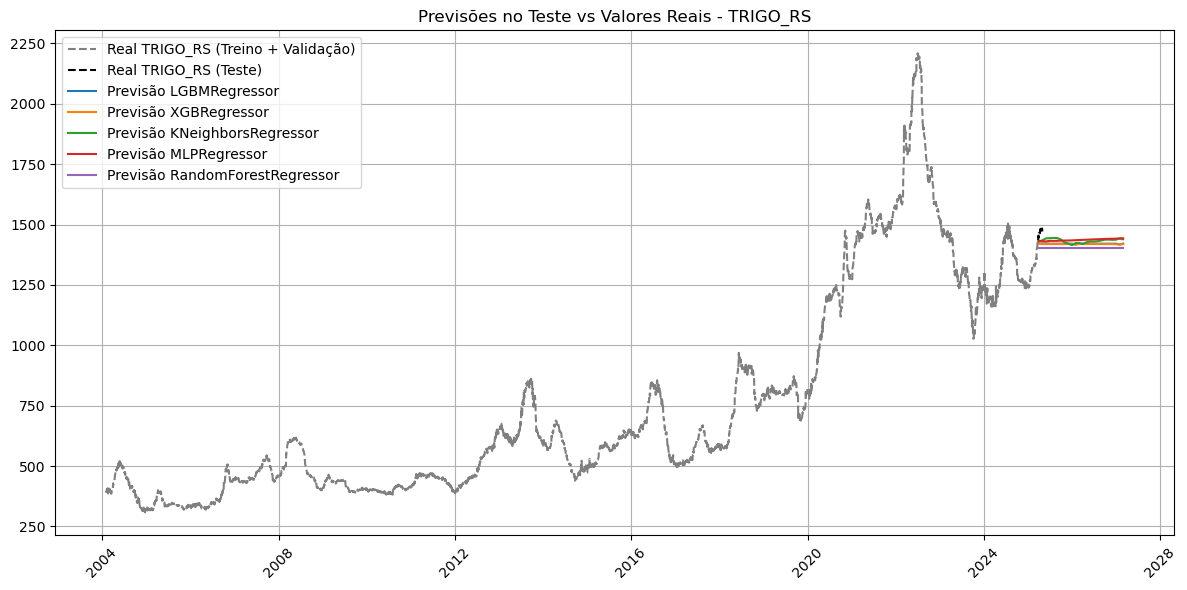

In [18]:
for commodity in Y_test_df_brl['unique_id'].unique():
    plot_test_forecasts(
        full_train=full_train,
        test_data=Y_test_df_brl,
        forecasts_test=forecasts_test,
        commodity=commodity,
        models=['LGBMRegressor', 'XGBRegressor', 'KNeighborsRegressor', 'MLPRegressor', 'RandomForestRegressor']
    )